In [1]:
import keras
import keras.backend
import tensorflow as tf
import netCDF4
import pandas
import sklearn.preprocessing
import sklearn.model_selection
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Using TensorFlow backend.


In [5]:
ds = netCDF4.Dataset('http://uhslc.soest.hawaii.edu/thredds/dodsC/uhslc/rqh/OS_UH-RQH260A_20160323_R')
# ds = netCDF4.Dataset('/Users/baart_f/models/sfo/reconstruction/OS_UH-RQH551A_20140806_R.nc')


In [6]:
lat, lon = ds.variables['latitude'][0], ds.variables['longitude'][0]
lat, lon

(35.182999, -75.75)

In [7]:
h = ds.variables['sea_surface_height_above_reference_level'][:, 0, 0, 0]
t = netCDF4.num2date(ds.variables['time'][:], ds.variables['time'].units)


In [8]:
df = pandas.DataFrame(dict(t=t, h=h))
df = df.set_index(t).dropna()
df['year'] = [x.year for x in df.index]

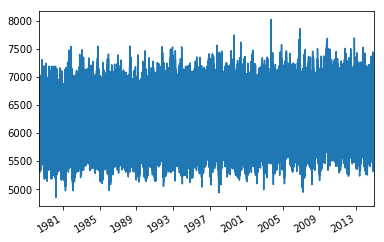

In [9]:
df['h'].plot()

In [10]:
import datetime
df = df.ix[df.index != pandas.Timestamp(1700, 1, 1)]

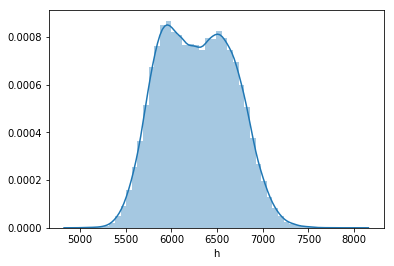

In [11]:
import seaborn
_ = seaborn.distplot(df['h'].tail(n=100000))


In [15]:
# LTSM expects data to be scaled
N = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
values = df['h'].values[:, np.newaxis]
# transform
N.fit(values)
print("min", N.data_min_, "range", N.data_range_)
scaled = N.transform(values)
df['h_scaled'] = np.squeeze(scaled)

min [ 4855.] range [ 3175.]


In [16]:
year_train, year_test, year_validate = np.random.choice(list(set(df.year)), 3)
year_train, year_test, year_validate = (2001, 2002, 2003)

In [30]:
def make_dataset(all_df, year):
    df = all_df.ix[all_df.year == year]
    # phase
#     hours = df.apply(lambda x:x.name.timestamp(), axis=1) / 3600
#     phase = 2*np.pi * (hours / 12.4206012)
#     phase_u = np.cos(phase)
#     phase_v = np.sin(phase)
    df_lookback = pandas.DataFrame(data=dict(
        t=df['t'].iloc[:-2],
        x_0=df['h_scaled'].values[:-2],
        x_1=df['h_scaled'].values[1:-1], 
        # phases
#         phase_u=phase_u.values[2:],
#         phase_v=phase_v.values[2:],
        y=df['h_scaled'].values[2:],
        h=df['h'].values[2:]
    ))
    return df_lookback.set_index('t')


In [46]:
df_train = make_dataset(df, year_train)
df_test = make_dataset(df, year_test)
df_validate = make_dataset(df, year_validate)
df_train.head()

,h,x_0,x_1,y
t,,,,
2001-01-01 00:00:00.000000,5836.0,0.224882,0.259528,0.308976
2001-01-01 01:00:00.000288,6018.0,0.259528,0.308976,0.366299
2001-01-01 01:59:59.999712,6093.0,0.308976,0.366299,0.389921
2001-01-01 03:00:00.000000,6092.0,0.366299,0.389921,0.389606
2001-01-01 04:00:00.000288,6022.0,0.389921,0.389606,0.367559


In [47]:
keras.callbacks.TensorBoard(
    log_dir='./logs', 
    histogram_freq=1, 
    batch_size=32, 
    write_graph=True, 
    write_grads=True, 
    write_images=True, 
    embeddings_freq=0, 
    embeddings_layer_names=None, 
    embeddings_metadata=None
)

# Create TF session and register it with Keras
# session = keras.backend.get_session()
# g = session.graph
# tf.summary.FileWriter("logs", g).close()

In [33]:
look_back = 2
model = keras.models.Sequential()
layer = keras.layers.LSTM(4, input_shape=(1, look_back))
model.add(layer)
layer = keras.layers.Dense(1)
model.add(layer)
model.compile(loss='mean_squared_error', optimizer='adam')

In [34]:
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4)                 112       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 117
Trainable params: 117
Non-trainable params: 0
_________________________________________________________________


In [35]:
import keras.utils.vis_utils
keras.utils.vis_utils.plot_model(model)

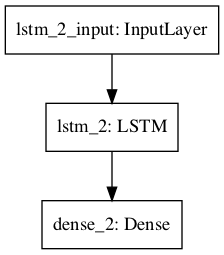

In [36]:
import IPython.display
IPython.display.Image('model.png')

In [38]:
X = np.dstack([
    df_train['x_0'].values[:, np.newaxis, np.newaxis], 
    df_train['x_1'].values[:, np.newaxis, np.newaxis]
#     df_train['phase_u'].values[:, np.newaxis, np.newaxis],
#     df_train['phase_v'].values[:, np.newaxis, np.newaxis]
])
Y = df_train['y'].values
print(X.shape, Y.shape)
history = model.fit(X, Y, epochs=2, batch_size=1, verbose=2)

(8758, 1, 2) (8758,)
Epoch 1/2
44s - loss: 0.0063
Epoch 2/2
42s - loss: 4.0304e-04


In [40]:

s = np.s_[50:100]
selection = df_test[s]
selection_X = np.dstack([
    selection['x_0'].values[:, np.newaxis, np.newaxis],
    selection['x_1'].values[:, np.newaxis, np.newaxis]
#     selection['phase_u'].values[:, np.newaxis, np.newaxis],
#     selection['phase_v'].values[:, np.newaxis, np.newaxis]
])

Y_test = model.predict(selection_X)

(730853.08333333, 730855.125)

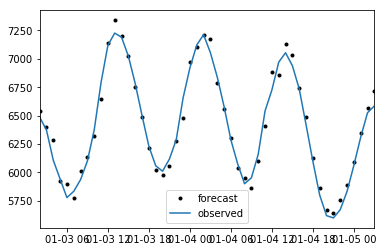

In [50]:
t = df_test.index[52:102]
plt.plot(selection.index, N.inverse_transform(Y_test), 'k.', label="forecast")
plt.plot(selection.index, selection['h'], label="observed")
plt.legend()
t = selection.index
plt.xlim(t[0], t[-1])

In [48]:
_ = model.predict(selection_X, batch_size=10)

In [43]:
forecasts = selection_X.copy()
for i in range(100):
    prediction = model.predict(forecasts)
    extra = np.array([forecasts[-1, 0, 1], prediction[-1, 0]]) #, forecasts[-1, 0, 2], forecasts[-1, 0, 3]])
    forecasts = np.vstack([
        forecasts, 
        extra[np.newaxis, np.newaxis, :]
    ])

/Users/baart_f/.virtualenvs/main/lib/python3.5/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


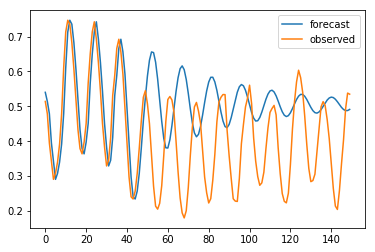

In [45]:
plt.plot(forecasts[:, 0, -1], label='forecast')
plt.plot(N.transform(df_test.ix[50:200]['h'].values), label='observed')
plt.legend()

# Current issues/questions

- How can make the simplest approach for this case, for example a standard MLP?
- The structure of the network, as viewed by the tensorboard is overly complex. Why? What do all the terms mean?
- Why is it so slow (training takes 2 minutes for 2 epochs, with almost no data, very few parameters)? 
- What is an optimal network for this use case? 
- How can we include exogenuous/independent variables like phase, wind, boundary forecasts?
- How can we explain the current behaviour? Why does it dampen out and not explode, why does it run out of phase?

